In [8]:
import numpy as np
import matplotlib.pyplot as plt
import libra_toolbox.neutron_detection.activation_foils.compass as compass
from libra_toolbox.neutron_detection.activation_foils.calibration import Nuclide, CheckSource
import datetime

True
False


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

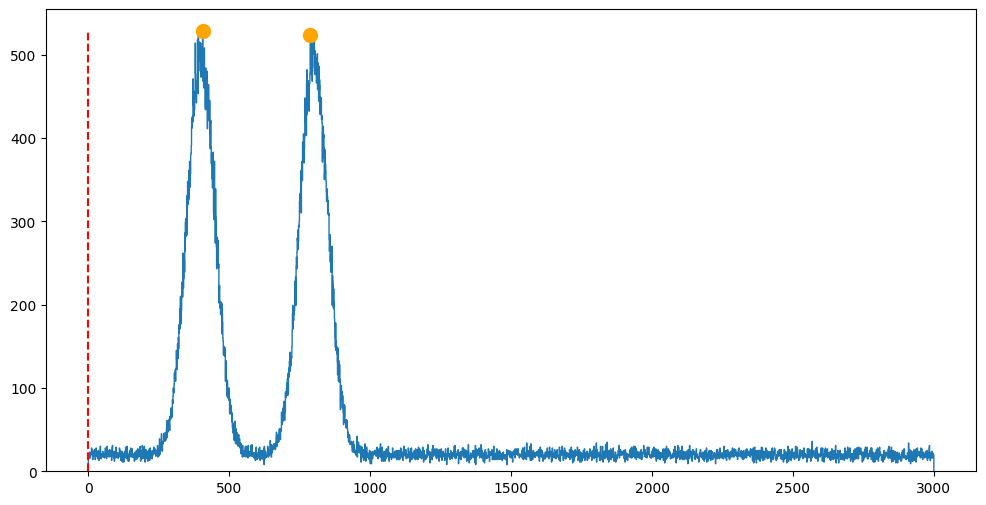

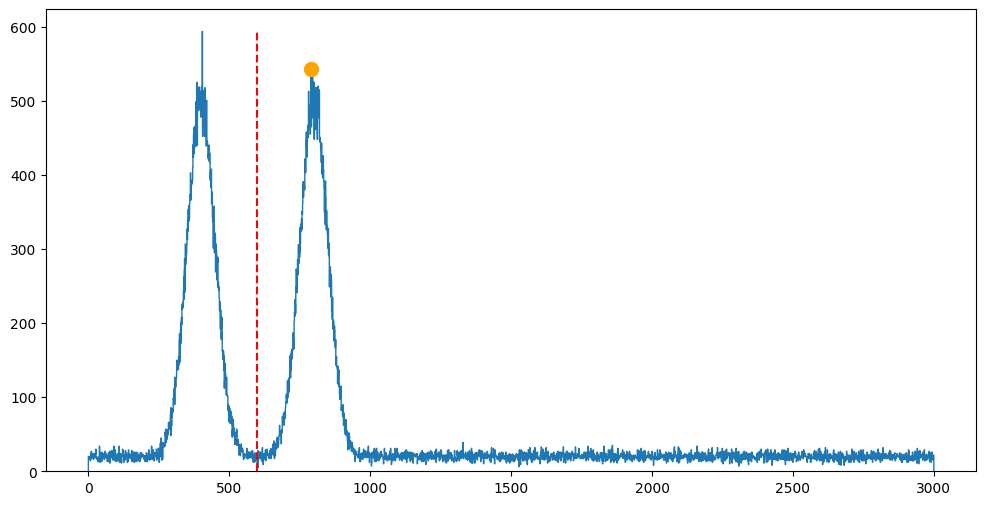

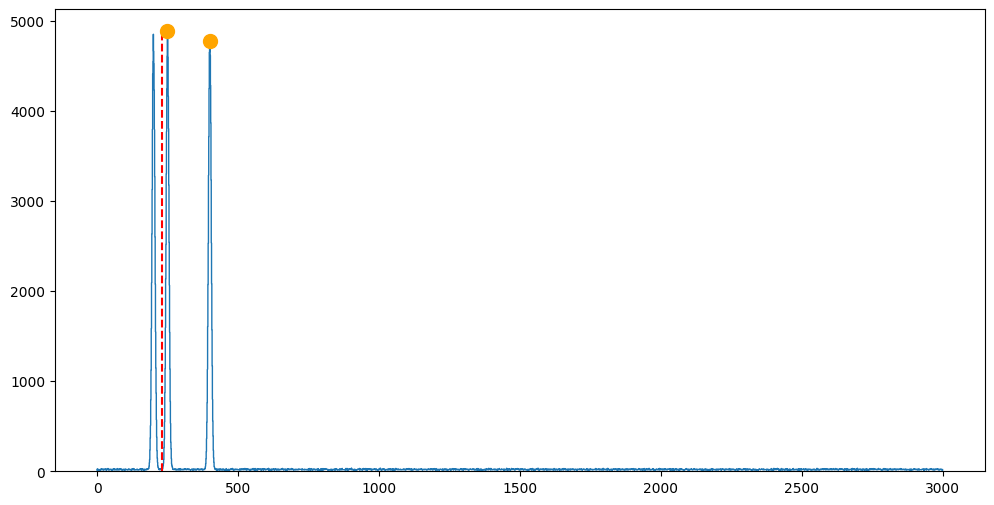

In [ ]:
nb_events_measured = 60000
channel_nb = 1
cases = [
        ([400, 800], 50, 0, [400, 800]),
        ([400, 800], 50, 600, [800]),
        ([200, 250, 400], 5, 230, [250, 400]),
    ]

for peak_energies, width, start_index, expected_peaks in cases:

    overall_energy_events = np.array([])

    for energy_level in peak_energies:
        energy_events = np.random.normal(
            loc=energy_level, scale=width, size=int(nb_events_measured)
        )
        overall_energy_events = np.concatenate((overall_energy_events, energy_events))

    random_noise = np.random.uniform(0, 3000, size=int(nb_events_measured))
    overall_energy_events = np.concatenate((overall_energy_events, random_noise))

    # make sure the min and max are in the range of the detector
    overall_energy_events[0] = 1
    overall_energy_events[-1] = 3000

    time_events = np.random.uniform(0, 100, size=int(nb_events_measured * (len(peak_energies) + 1)))

    test_nuclide = Nuclide(
        name="TestNuclide",
        energy=peak_energies,
        intensity=[1.0]*len(peak_energies),
        half_life=10000,
    )
    check_source = CheckSource(
        nuclide=test_nuclide,
        activity_date=datetime.datetime(2024, 11, 7),
        activity=5000,
    )

    # create CheckSourceMeasurement
    measurement = compass.CheckSourceMeasurement(name="test measurement")
    measurement.check_source = check_source
    # measurement.start_time = datetime.datetime(2024, 11, 7)
    detector = compass.Detector(channel_nb=channel_nb, nb_digitizer_bins=None)
    detector.events = np.column_stack((time_events, overall_energy_events))
    hist, bins = detector.get_energy_hist(bins=None)

    peak_indices = measurement.get_peaks(hist, start_index=start_index)


    fig, ax = plt.subplots(figsize=(12, 6))
    ax.stairs(hist, bins)
    ax.vlines(bins[start_index], 0, np.max(hist), colors="r", linestyles="dashed")
    ax.plot(bins[peak_indices], hist[peak_indices], "o", color="orange", markersize=10)


    print(len(peak_indices) == len(expected_peaks))
    print(np.allclose(expected_peaks - bins[peak_indices], 0, atol=2*width))